## Install TensorTrade

In [1]:
#!python3 -m pip install git+https://github.com/tensortrade-org/tensortrade.git

## Setup Data Fetching

In [2]:
from tensortrade.data.cdd import CryptoDataDownload

import numpy as np
import pandas as pd
pd.options.mode.use_inf_as_na = True

def prepare_data(df):
    df['volume'] = np.int64(df['volume'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d %I:%M %p')
    return df

def fetch_data():
    cdd = CryptoDataDownload()
    bitfinex_data = cdd.fetch("Bitfinex", "USD", "BTC", "1h")
    bitfinex_data = bitfinex_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    bitfinex_data = prepare_data(bitfinex_data)
    return bitfinex_data

def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp from "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    return prepare_data(df)

In [3]:
data = fetch_data()
data

,date,open,high,low,close,volume
0,2018-05-15 06:00 AM,8723.8,8793.000000,8714.900000,8739.000000,8988053
1,2018-05-15 07:00 AM,8739.0,8754.800000,8719.300000,8743.000000,2288904
2,2018-05-15 08:00 AM,8743.0,8743.100000,8653.200000,8723.700000,8891773
3,2018-05-15 09:00 AM,8723.7,8737.800000,8701.200000,8708.100000,2054868
4,2018-05-15 10:00 AM,8708.1,8855.700000,8695.800000,8784.400000,17309722
...,...,...,...,...,...,...
32817,2022-02-10 08:00 PM,44413.0,44638.869469,43850.000000,44120.993145,18186411
32818,2022-02-10 09:00 PM,44150.0,44231.954330,43741.000000,43779.000000,14875298
32819,2022-02-10 10:00 PM,43794.0,44145.000000,43657.245134,44007.382562,9283926
32820,2022-02-10 11:00 PM,44009.0,44103.000000,43384.000000,43545.000000,8909147


## Create features with the feed module

In [4]:
fill_value = data.apply(lambda x: x.iloc[x.first_valid_index()], axis='index')
data.iloc[0,:] = fill_value
data

,date,open,high,low,close,volume
0,2018-05-15 06:00 AM,8723.8,8793.000000,8714.900000,8739.000000,8988053
1,2018-05-15 07:00 AM,8739.0,8754.800000,8719.300000,8743.000000,2288904
2,2018-05-15 08:00 AM,8743.0,8743.100000,8653.200000,8723.700000,8891773
3,2018-05-15 09:00 AM,8723.7,8737.800000,8701.200000,8708.100000,2054868
4,2018-05-15 10:00 AM,8708.1,8855.700000,8695.800000,8784.400000,17309722
...,...,...,...,...,...,...
32817,2022-02-10 08:00 PM,44413.0,44638.869469,43850.000000,44120.993145,18186411
32818,2022-02-10 09:00 PM,44150.0,44231.954330,43741.000000,43779.000000,14875298
32819,2022-02-10 10:00 PM,43794.0,44145.000000,43657.245134,44007.382562,9283926
32820,2022-02-10 11:00 PM,44009.0,44103.000000,43384.000000,43545.000000,8909147


In [5]:
import os
import numpy as np
import ta as ta1
import pandas_ta as ta

import quantstats as qs
qs.extend_pandas()

def fix_dataset_inconsistencies(dataframe, fill_value=None):
    dataframe = dataframe.replace([-np.inf, np.inf], np.nan)
    if fill_value is None:
        dataframe.iloc[0,:] = \
            dataframe.apply(lambda column: column.iloc[column.first_valid_index()], axis='index')
    else:
        dataframe.iloc[0,:] = dataframe.iloc[0,:].fillna(fill_value)
    return dataframe.fillna(axis='index', method='pad').dropna(axis='columns')

def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    r = price.diff()
    upside = np.minimum(r, 0).abs()
    downside = np.maximum(r, 0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def generate_all_default_quantstats_features(data):
    excluded_indicators = [
        'compare',
        'greeks',
        'information_ratio',
        'omega',
        'r2',
        'r_squared',
        'rolling_greeks',
        'warn',
    ]
    
    indicators_list = [f for f in dir(qs.stats) if f[0] != '_' and f not in excluded_indicators]
    
    df = data.copy()
    df = df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)

    for indicator_name in indicators_list:
        try:
            #print(indicator_name)
            indicator = qs.stats.__dict__[indicator_name](df['close'])
            if isinstance(indicator, pd.Series):
                indicator = indicator.to_frame(name=indicator_name)
                df = pd.concat([df, indicator], axis='columns')
        except (pd.errors.InvalidIndexError, ValueError):
            pass

    df = df.reset_index()
    return df

def generate_features(data):
    # Automatically-generated using pandas_ta
    df = data.copy()

    strategies = ['candles', 
                  'cycles', 
                  'momentum', 
                  'overlap', 
                  'performance', 
                  'statistics', 
                  'trend', 
                  'volatility', 
                  'volume']

    df.index = pd.DatetimeIndex(df.index)

    cores = os.cpu_count()
    df.ta.cores = cores

    for strategy in strategies:
        df.ta.study(strategy, exclude=['kvo'])

    df = df.set_index('date')

    # Generate all default indicators from ta library
    ta1.add_all_ta_features(data, 
                            'open', 
                            'high', 
                            'low', 
                            'close', 
                            'volume', 
                            fillna=True)

    # Naming convention across most technical indicator libraries
    data = data.rename(columns={'open': 'Open', 
                                'high': 'High', 
                                'low': 'Low', 
                                'close': 'Close', 
                                'volume': 'Volume'})
    data = data.set_index('date')

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'vol_5': data['Close'].rolling(window=5).std().abs(),
        'vol_10': data['Close'].rolling(window=10).std().abs(),
        'vol_20': data['Close'].rolling(window=20).std().abs(),
        'vol_30': data['Close'].rolling(window=30).std().abs(),
        'vol_50': data['Close'].rolling(window=50).std().abs(),
        'vol_60': data['Close'].rolling(window=60).std().abs(),
        'vol_100': data['Close'].rolling(window=100).std().abs(),
        'vol_200': data['Close'].rolling(window=200).std().abs(),
        'ma_5': data['Close'].rolling(window=5).mean(),
        'ma_10': data['Close'].rolling(window=10).mean(),
        'ma_20': data['Close'].rolling(window=20).mean(),
        'ma_30': data['Close'].rolling(window=30).mean(),
        'ma_50': data['Close'].rolling(window=50).mean(),
        'ma_60': data['Close'].rolling(window=60).mean(),
        'ma_100': data['Close'].rolling(window=100).mean(),
        'ma_200': data['Close'].rolling(window=200).mean(),
        'ema_5': ta1.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_10': ta1.trend.ema_indicator(data['Close'], window=10, fillna=True),
        'ema_20': ta1.trend.ema_indicator(data['Close'], window=20, fillna=True),
        'ema_60': ta1.trend.ema_indicator(data['Close'], window=60, fillna=True),
        'ema_64': ta1.trend.ema_indicator(data['Close'], window=64, fillna=True),
        'ema_120': ta1.trend.ema_indicator(data['Close'], window=120, fillna=True),
        'lr_open': np.log(data['Open']).diff().fillna(0),
        'lr_high': np.log(data['High']).diff().fillna(0),
        'lr_low': np.log(data['Low']).diff().fillna(0),
        'lr_close': np.log(data['Close']).diff().fillna(0),
        'r_volume': data['Close'].diff().fillna(0),
        'rsi_5': rsi(data['Close'], period=5),
        'rsi_10': rsi(data['Close'], period=10),
        'rsi_100': rsi(data['Close'], period=100),
        'rsi_7': rsi(data['Close'], period=7),
        'rsi_28': rsi(data['Close'], period=28),
        'rsi_6': rsi(data['Close'], period=6),
        'rsi_14': rsi(data['Close'], period=14),
        'rsi_26': rsi(data['Close'], period=24),
        'macd_normal': macd(data['Close'], fast=12, slow=26, signal=9),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50),
    })

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    data = data.reset_index()

    # Generate all default quantstats features
    df_quantstats = generate_all_default_quantstats_features(data)

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df_quantstats], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    data = fix_dataset_inconsistencies(data, fill_value=None)
    return data

In [6]:
data = generate_features(data)
data.tail()

/usr/lib/python3.8/multiprocessing/pool.py:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return list(map(*args))
/usr/local/lib/python3.8/dist-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence t

,date,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,TSVs_18_10,TSVr_18_10,compsum,implied_volatility,outliers,pct_rank,rolling_sharpe,rolling_sortino,rolling_volatility,to_drawdown_series
32617,2022-02-10 08:00 PM,44413.0,44638.869469,43850.000000,44120.993145,18186411,1.024530e+10,-4351109423,-0.106572,-1.355731e+09,...,-6.991619e+09,1.526803,5.262897e+305,0.111933,58050.523526,56.666667,1.158142,1.702335,0.111575,-0.356846
32618,2022-02-10 09:00 PM,44150.0,44231.954330,43741.000000,43779.000000,14875298,1.023272e+10,-4365984721,-0.148958,-1.888805e+09,...,-9.253408e+09,1.689492,5.262897e+305,0.112247,58050.523526,31.666667,0.879502,1.280963,0.111703,-0.361831
32619,2022-02-10 10:00 PM,43794.0,44145.000000,43657.245134,44007.382562,9283926,1.023677e+10,-4356700795,-0.119184,-1.316078e+09,...,-1.118799e+10,1.202360,5.262897e+305,0.112327,58050.523526,48.333333,1.189057,1.754568,0.110627,-0.358502
32620,2022-02-10 11:00 PM,44009.0,44103.000000,43384.000000,43545.000000,8909147,1.023185e+10,-4365609942,-0.141175,-1.716557e+09,...,-7.441492e+09,2.373274,5.262897e+305,0.112880,58050.523526,20.000000,0.867601,1.263808,0.111332,-0.365242
32621,2022-02-11 12:00 AM,43549.0,43613.714273,43030.000000,43041.796503,4433225,1.022759e+10,-4370043167,-0.157730,-1.790022e+09,...,-5.594484e+09,3.551736,5.262897e+305,0.113394,58050.523526,5.000000,0.612706,0.882489,0.112571,-0.372578


## TODO: implement feature engineering

## Split dataset

In [7]:
from sklearn.model_selection import train_test_split

def split_data(data):
    X = data.copy()
    y = X['close'].pct_change()

    X_train_test, X_valid, y_train_test, y_valid = \
        train_test_split(data, data['close'].pct_change(), train_size=0.67, test_size=0.33, shuffle=False)

    X_train, X_test, y_train, y_test = \
        train_test_split(X_train_test, y_train_test, train_size=0.50, test_size=0.50, shuffle=False)

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [8]:
X_train, X_test, X_valid, y_train, y_test, y_valid = \
    split_data(data)

import os
cwd = os.getcwd()
train_csv = os.path.join(cwd, 'train.csv')
test_csv = os.path.join(cwd, 'test.csv')
valid_csv = os.path.join(cwd, 'valid.csv')
X_train.to_csv(train_csv, index=False)
X_test.to_csv(test_csv, index=False)
X_valid.to_csv(valid_csv, index=False)

## Normalize the dataset subsets to make the model converge faster

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def get_feature_scalers(X, scaler_type=MinMaxScaler):
    scalers = []
    for name in list(X.columns[X.columns != 'date']):
        scalers.append(scaler_type().fit(X[name].values.reshape(-1, 1)))
    return scalers

def get_scaler_transforms(X, scalers):
    X_scaled = []
    for name, scaler in zip(list(X.columns[X.columns != 'date']), scalers):
        X_scaled.append(scaler.transform(X[name].values.reshape(-1, 1)))
    X_scaled = pd.concat([pd.DataFrame(column, columns=[name]) for name, column in \
                          zip(list(X.columns[X.columns != 'date']), X_scaled)], axis='columns')
    return X_scaled

def normalize_data(X_train, X_test, X_valid):
    X_train_test = pd.concat([X_train, X_test], axis='index')
    X_train_test_valid = pd.concat([X_train_test, X_valid], axis='index')

    X_train_test_dates = X_train_test[['date']]
    X_train_test_valid_dates = X_train_test_valid[['date']]

    X_train_test = X_train_test.drop(columns=['date'])
    X_train_test_valid = X_train_test_valid.drop(columns=['date'])

    train_test_scalers = \
        get_feature_scalers(X_train_test, 
                            scaler_type=MinMaxScaler)
    train_test_valid_scalers = \
        get_feature_scalers(X_train_test_valid, 
                            scaler_type=MinMaxScaler)

    X_train_test_scaled = \
        get_scaler_transforms(X_train_test, 
                              train_test_scalers)
    X_train_test_valid_scaled = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_scalers)
    X_train_test_valid_scaled_leaking = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_valid_scalers)

    X_train_test_scaled = \
        pd.concat([X_train_test_dates, 
                   X_train_test_scaled], 
                  axis='columns')
    X_train_test_valid_scaled = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled], 
                  axis='columns')
    X_train_test_valid_scaled_leaking = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled_leaking], 
                  axis='columns')

    X_train_scaled = X_train_test_scaled.iloc[:X_train.shape[0]]
    X_test_scaled = X_train_test_scaled.iloc[X_train.shape[0]:]
    X_valid_scaled = X_train_test_valid_scaled.iloc[X_train_test.shape[0]:]
    X_valid_scaled_leaking = X_train_test_valid_scaled_leaking.iloc[X_train_test.shape[0]:]

    return (train_test_scalers, 
            train_test_valid_scalers, 
            X_train_scaled, 
            X_test_scaled, 
            X_valid_scaled, 
            X_valid_scaled_leaking)

In [12]:
train_test_scalers, train_test_valid_scalers, X_train_scaled, X_test_scaled, X_valid_scaled, X_valid_scaled_leaking = \
    normalize_data(X_train, X_test, X_valid)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## Setup Trading Environment (TODO: rewrite action scheme and reward scheme)

In [13]:
import tensortrade.env.default as default

from tensortrade.agents import DQNAgent
from tensortrade.feed.core import DataFeed, Stream
from tensortrade.feed.core.base import NameSpace
from tensortrade.env.default.actions import ManagedRiskOrders
from tensortrade.env.default.rewards import RiskAdjustedReturns
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.oms.orders import TradeType

bitstamp = Exchange("bitstamp", service=execute_order)(
    Stream.source(list(X_valid["close"]), dtype="float").rename("USD-BTC")
)

portfolio = Portfolio(USD, [
    Wallet(bitstamp, 50000 * USD),
    Wallet(bitstamp, 1 * BTC)
])

with NameSpace("bitstamp"):
    features = [
        #Stream.source(list(X_valid_scaled[c]), 
        #              dtype="float").rename(c) for c in X_train_scaled.columns[1:]
        Stream.source(list(X_valid_scaled['lr_high']), dtype="float").rename('lr_high')
    ]

feed = DataFeed(features)
feed.compile()

renderer_feed = DataFeed([
    Stream.source(list(X_valid["date"])).rename("date"),
    Stream.source(list(X_valid["open"]), dtype="float").rename("open"),
    Stream.source(list(X_valid["high"]), dtype="float").rename("high"),
    Stream.source(list(X_valid["low"]), dtype="float").rename("low"),
    Stream.source(list(X_valid["close"]), dtype="float").rename("close"), 
    Stream.source(list(X_valid["volume"]), dtype="float").rename("volume") 
])

#action_scheme = ManagedRiskOrders(stop=[0.06, 0.12, 0.18],
#                                  take=[0.03, 0.06, 0.09],
#                                  trade_sizes=2,
#                                  durations=None,
#                                  trade_type=TradeType.MARKET,
#                                  order_listener=None,
#                                  min_order_pct=0.06,
#                                  min_order_abs=0.00)

action_scheme = ManagedRiskOrders(stop=[0.50],
                                  take=[0.25],
                                  trade_sizes=1,
                                  durations=None,
                                  trade_type=TradeType.MARKET,
                                  order_listener=None,
                                  min_order_pct=0.06,
                                  min_order_abs=0.00)

reward_scheme = RiskAdjustedReturns(return_algorithm='sortino',
                                    window_size=30)

env = default.create(
    portfolio=portfolio,
    action_scheme=action_scheme,
    reward_scheme=reward_scheme,
    feed=feed,
    renderer_feed=renderer_feed,
    renderer=default.renderers.PlotlyTradingChart(),
    window_size=30
)

In [14]:
env.observer.feed.next()

{'internal': {'bitstamp:/USD-BTC': 17744.0,
  'bitstamp:/USD:/free': 50000.0,
  'bitstamp:/USD:/locked': 0.0,
  'bitstamp:/USD:/total': 50000.0,
  'bitstamp:/BTC:/free': 1.0,
  'bitstamp:/BTC:/locked': 0.0,
  'bitstamp:/BTC:/total': 1.0,
  'bitstamp:/BTC:/worth': 17744.0,
  'net_worth': 67744.0},
 'external': {'bitstamp:/lr_high': 0.4762157569676644},
 'renderer': {'date': '2020-11-19 06:00 AM',
  'open': 17887.532676,
  'high': 17894.0,
  'low': 17667.0,
  'close': 17744.0,
  'volume': 6976676}}

## TODO: implement tuning

## TODO: compare with PPO and SAC

## Setup and Train DQN Agent

In [15]:
n_steps = 2000
n_episodes = 20
window_size = 30
memory_capacity = n_steps * 10
save_path = 'agents/'

In [16]:
def get_optimal_batch_size(window_size=30, n_steps=1000, batch_factor=4, stride=1):
    """
    lookback = 30          # Days of past data (also named window_size).
    batch_factor = 4       # batch_size = (sample_size - lookback - stride) // batch_factor
    stride = 1             # Time series shift into the future.
    """
    lookback = window_size
    sample_size = n_steps
    batch_size = ((sample_size - lookback - stride) // batch_factor)
    return batch_size

batch_size = get_optimal_batch_size(window_size=window_size, n_steps=n_steps, batch_factor=4)
batch_size

492

%matplotlib inline

In [17]:
agent = DQNAgent(env)

agent.train(batch_size=batch_size, 
            n_steps=n_steps, 
            n_episodes=n_episodes, 
            memory_capacity=memory_capacity, 
            save_path=save_path)

FigureWidget({
    'data': [{'close': array([17744., 17645., 17528., ..., 45760., 45631., 44982.]),
          …

FigureWidget({
    'data': [{'close': array([17744.        , 17645.        , 17528.        , ..., 17150.      …

FigureWidget({
    'data': [{'close': array([17744., 17645., 17528., ..., 19052., 19013., 19024.]),
          …

KeyboardInterrupt: 

## Implement validation here

## Print basic quantstats report (warning: uses default parameters!)

                           Strategy
-------------------------  ----------
Start Period               2018-05-23
End Period                 2020-05-09
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          26.35%
CAGR﹪                     12.64%

Sharpe                     0.79
Smart Sharpe               0.77
Sortino                    1.16
Smart Sortino              1.13
Sortino/√2                 0.82
Smart Sortino/√2           0.8
Omega                      1.15

Max Drawdown               -14.49%
Longest DD Days            359
Volatility (ann.)          11.15%
Calmar                     0.87
Skew                       -0.15
Kurtosis                   4.48

Expected Daily %           0.03%
Expected Monthly %         0.94%
Expected Yearly %          8.11%
Kelly Criterion            6.89%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.12%
Expected Shortfall (cVaR)  -1.12%

Gain/Pain Ratio            0.15
Gain/Pain (1M)             1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-08-29,2018-11-09,2019-01-19,143,-14.490882,-14.178414
2,2019-02-09,2019-10-07,2020-02-03,359,-10.669160,-9.846992
3,2018-06-04,2018-07-08,2018-08-23,80,-5.149555,-3.998727
4,2020-03-05,2020-03-27,2020-04-19,45,-3.065315,-3.009480
5,2020-04-22,2020-05-02,2020-05-09,17,-2.722875,-2.464348


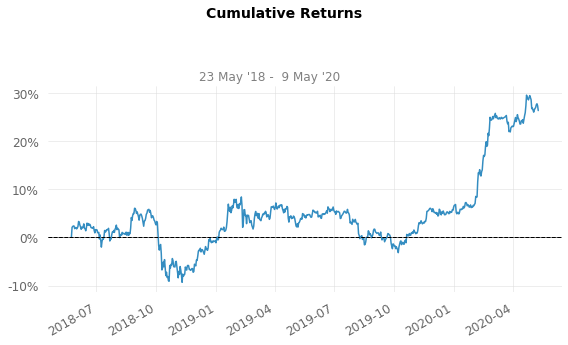

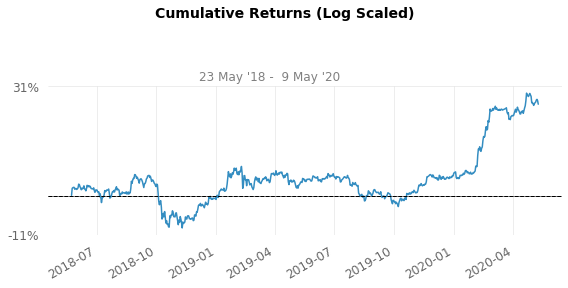

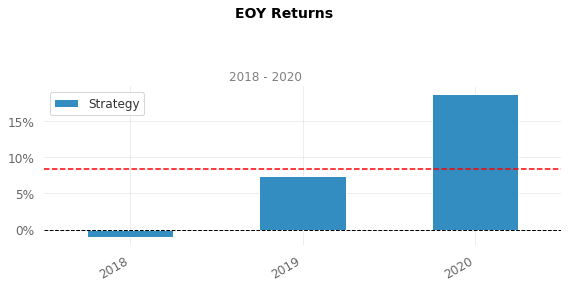

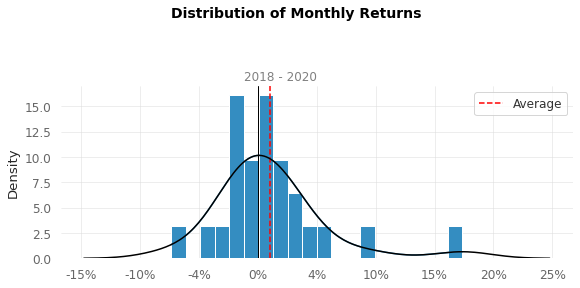

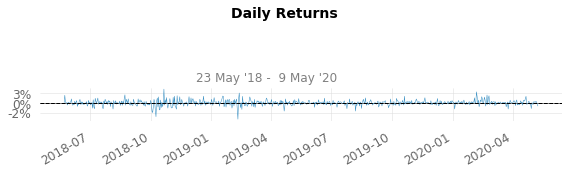

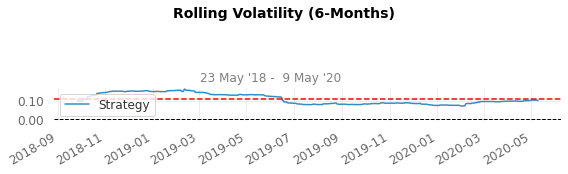

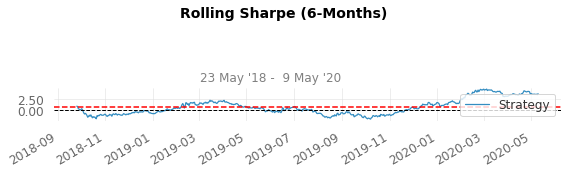

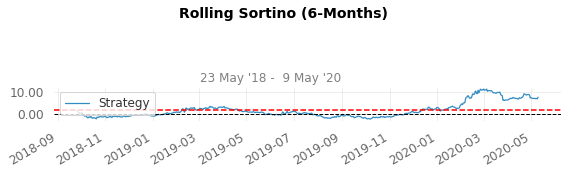

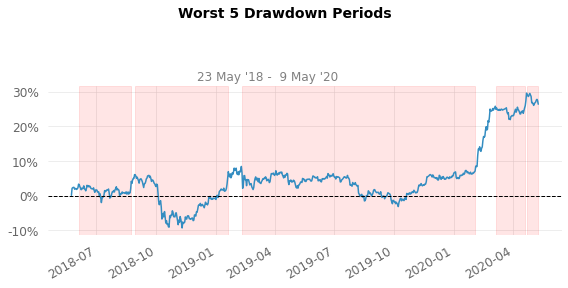

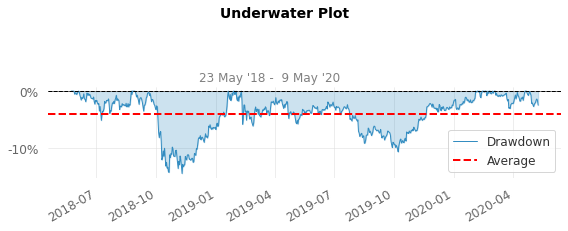

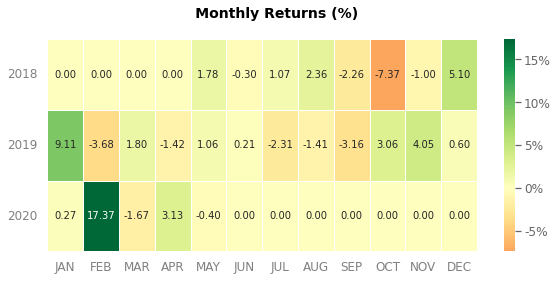

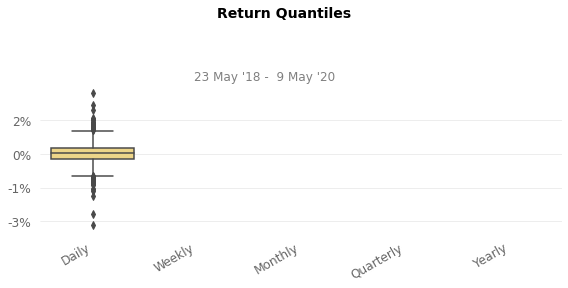

In [95]:
def print_quantstats_full_report(env, data, output='dqn_quantstats'):
    performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
    net_worth = performance['net_worth'].iloc[window_size:]
    returns = net_worth.pct_change().iloc[1:]

    # WARNING! The dates are fake!
    returns.index = pd.date_range(start=data['date'].iloc[0], freq='1d', periods=returns.size)

    qs.reports.full(returns)
    qs.reports.html(returns, output=output + '.html')

print_quantstats_full_report(env, data)